In [80]:
import pandas as pd
import numpy as np
from scripts import *
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import seaborn as sns
from scipy import stats
import warnings
from shapely.geometry import Point,Polygon
import geopandas as gpd
import descartes
import contextily as ctx
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')
%matplotlib inline

In [38]:
# importing main data
training_data = pd.read_csv('/Users/brendanferris/Desktop/kings_county_housing/kc_house_data_train.csv')
missing_vals = pd.read_csv('bedroomsfilled.csv')
holdout_data = pd.read_csv('/Users/brendanferris/Desktop/kings_county_housing/kc_house_data_train.csv')

# Housing Prices: first look.

In [92]:
len_ten_percent = int(len(training_data)*.10)
average_top_prices = np.mean(training_data.price.sort_values(ascending=False)[:len_ten_percent])
average_lower_prices = np.mean(training_data.price.sort_values()[:len_ten_percent])

print("The highest 10% of houses are priced above ${}, while the lowest 10% are priced below ${}".format(int(average_top_prices), int(average_lower_prices)))

The highest 10% of houses are priced above $1350116, while the lowest 10% are priced below $203451


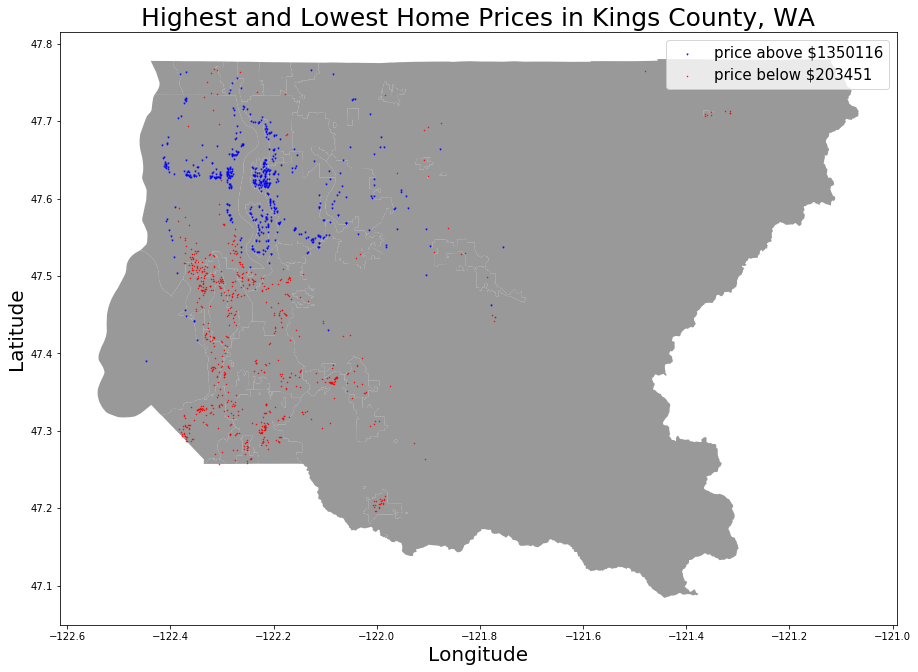

In [94]:
king_map = gpd.read_file('/Users/brendanferris/Desktop/kings_county_housing/EDA/Cities_and_Unincorporated_King_County___city_kc_area-shp')
geometry = [Point(x,y) for x,y in zip(training_data['long'], training_data['lat'])]
geo_df = gpd.GeoDataFrame(training_data, crs = crs, geometry = geometry)

fig, ax = plt.subplots(figsize = (15,15))
king_map.plot(ax=ax, alpha = 0.8, color = 'grey')

geo_df[geo_df['price'] > average_top_prices].plot(ax = ax , markersize = 1,
                   color = 'blue',marker = 'v', aspect = 1.5, label="price above ${}".format(int(average_top_prices)))
geo_df[geo_df['price'] < average_lower_prices].plot(ax = ax , markersize = 1,
                   color = 'red',marker = '.',aspect = 1.5, label = "price below ${}".format(int(average_lower_prices)))

ax.set_title('Highest and Lowest Home Prices in Kings County, WA', fontdict =
             {'fontsize': 25})

ax.set_ylabel('Latitude',fontdict = {'fontsize': 20})
ax.set_xlabel('Longitude',fontdict = {'fontsize': 20})
plt.legend(prop={"size":15});

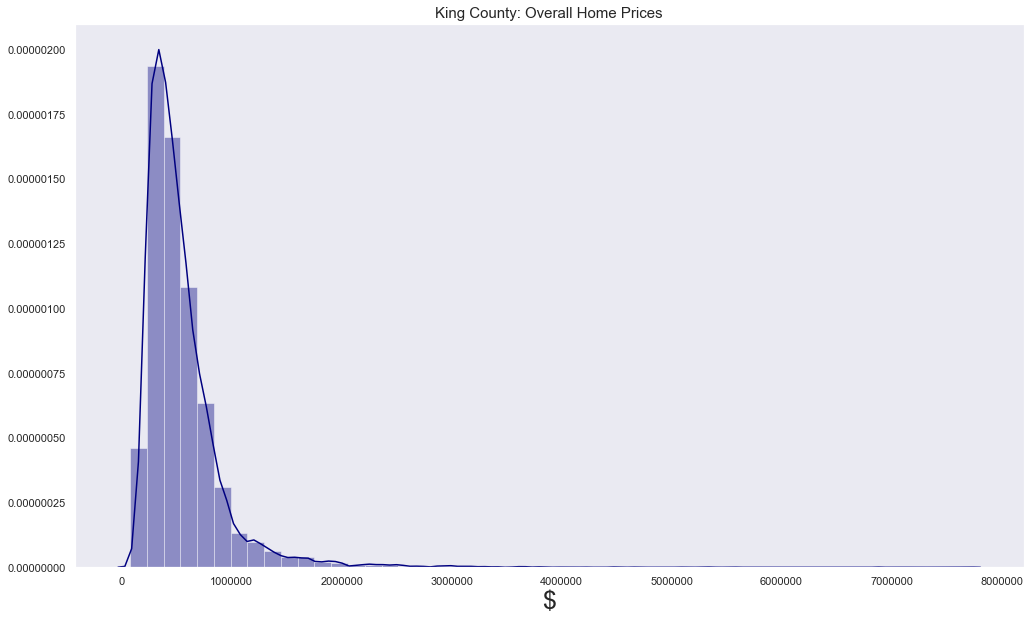

In [149]:
#fig, ax = plt.subplots(figsize = (15,15))
sns.set_style('dark')
sns.distplot(training_data['price'], color='navy')

sns.set(rc={'figure.figsize':(17,10)})
plt.xlabel("$", fontsize= 25)
plt.title("King County: Overall Home Prices", fontsize= 15);

# Adding Additional Zipcode Information

Additional zipcode information was collected from [here](https://www.unitedstateszipcodes.org) to allow for additional relevant features. 

In [5]:
# import additional zipcode data
zipcode_data = pd.read_excel('/Users/brendanferris/Desktop/kings_county_housing/EDA/extradata.xlsx', index_col='zipcode')
clean_data(training_data)
clean_data(missing_vals)

#replaced missing values with correct info from zillow.
training_data = no_bedrooms(training_data, missing_vals)

#merge the original data with additional zipcode data. 
training_data = pd.merge(training_data, zipcode_data, how='right', on='zipcode')

#replace 33 bedrooms with correct value
training_data.set_value(8597, 'bedrooms', 3).head(3)

(17290, 23)


,bathrooms,bedrooms,condition,floors,geometry,grade,id,lat,long,price,...,median_household_income,median_home_value,total_housing_units,land_area,water_area_sq_mile,owned_household_with_mortgage,renter_occupied_households,houses_owned_outright,sold_and_unoccupied,seasonal_or_rec_use
0,2.25,4,4,2.0,POINT (-122.162 47.4388),8,2591820310,47.4388,-122.162,365000.0,...,77780,302200,16120,18.93,0.83,8929,4196,2270,35,58
1,1.75,4,4,1.0,POINT (-122.084 47.4492),7,5112800060,47.4492,-122.084,455000.0,...,77780,302200,16120,18.93,0.83,8929,4196,2270,35,58
2,1.75,3,4,2.0,POINT (-122.18 47.4572),6,1423400260,47.4572,-122.180,273000.0,...,77780,302200,16120,18.93,0.83,8929,4196,2270,35,58


In [6]:
training_data['available_housing'] = training_data['total_housing_units'] - training_data['occupied_housing_units']

In [7]:
training_data

,bathrooms,bedrooms,condition,floors,geometry,grade,id,lat,long,price,...,median_home_value,total_housing_units,land_area,water_area_sq_mile,owned_household_with_mortgage,renter_occupied_households,houses_owned_outright,sold_and_unoccupied,seasonal_or_rec_use,available_housing
0,2.25,4,4,2.0,POINT (-122.162 47.4388),8,2591820310,47.4388,-122.162,365000.0,...,302200,16120,18.93,0.83,8929,4196,2270,35,58,725
1,1.75,4,4,1.0,POINT (-122.084 47.4492),7,5112800060,47.4492,-122.084,455000.0,...,302200,16120,18.93,0.83,8929,4196,2270,35,58,725
2,1.75,3,4,2.0,POINT (-122.18 47.4572),6,1423400260,47.4572,-122.180,273000.0,...,302200,16120,18.93,0.83,8929,4196,2270,35,58,725
3,1.00,2,3,1.0,POINT (-122.184 47.4572),6,1423200170,47.4572,-122.184,223000.0,...,302200,16120,18.93,0.83,8929,4196,2270,35,58,725
4,3.00,5,4,1.0,POINT (-122.149 47.4416),8,1402100070,47.4416,-122.149,335500.0,...,302200,16120,18.93,0.83,8929,4196,2270,35,58,725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,3.75,4,3,1.0,POINT (-122.236 47.639),9,2425049107,47.6390,-122.236,1950000.0,...,1000001,1163,1.44,4.30,567,116,379,9,19,101
17286,4.25,7,3,2.0,POINT (-122.227 47.6183),11,2210500010,47.6183,-122.227,2450000.0,...,1000001,1163,1.44,4.30,567,116,379,9,19,101
17287,1.75,4,3,2.0,POINT (-122.235 47.6236),9,3025300226,47.6236,-122.235,2100000.0,...,1000001,1163,1.44,4.30,567,116,379,9,19,101
17288,2.25,4,4,2.0,POINT (-122.236 47.6232),9,3025300250,47.6232,-122.236,1620000.0,...,1000001,1163,1.44,4.30,567,116,379,9,19,101


# Min/Max Scaling

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_feat = ['pop_density',
               'sqft_living15', 
               'sqft_above', 
               'sqft_basement',
               'bedrooms',
               'bathrooms',
               'median_household_income',
               'median_home_value',
               'sqft_lot']


training_data[scaled_feat] = scaler.fit_transform(training_data[scaled_feat])  

# Creating Dummies For Categorical Variables

In [9]:
waterfront_dummies = pd.get_dummies(training_data['waterfront'], prefix='waterf', drop_first=True)
view_dummies = pd.get_dummies(training_data['view'], prefix='has_view', drop_first=True)
condition_dummies = pd.get_dummies(training_data['condition'], prefix='condition', drop_first=True)
grade_dummies = pd.get_dummies(training_data['grade'], prefix='grade', drop_first=True)
month_dummies = pd.get_dummies(training_data['sale_month'], prefix='month', drop_first=True)
zip_dummies = pd.get_dummies(training_data['zipcode'], prefix='zip', drop_first=True)


training_data = training_data.drop(['postoffice','id','zipcode','sale_month','waterfront', 'view', 'condition', 'grade'], axis=1)
training_data = pd.concat([training_data, waterfront_dummies, view_dummies, condition_dummies, grade_dummies, month_dummies, zip_dummies], axis=1)
training_data.head(5)

,bathrooms,bedrooms,floors,geometry,lat,long,price,sale_year,sqft_above,sqft_basement,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,0.28125,0.09375,2.0,POINT (-122.162 47.4388),47.4388,-122.162,365000.0,2014,0.195175,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0.21875,0.09375,1.0,POINT (-122.084 47.4492),47.4492,-122.084,455000.0,2014,0.105263,0.165975,...,0,0,0,0,0,0,0,0,0,0
2,0.21875,0.06250,2.0,POINT (-122.18 47.4572),47.4572,-122.180,273000.0,2015,0.192982,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.12500,0.03125,1.0,POINT (-122.184 47.4572),47.4572,-122.184,223000.0,2014,0.067982,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0.37500,0.12500,1.0,POINT (-122.149 47.4416),47.4416,-122.149,335500.0,2014,0.154605,0.112033,...,0,0,0,0,0,0,0,0,0,0


# Removing Colinear Features

In [10]:
training_data.drop(['zip_98003',
                    'owned_household_with_mortgage', 
                    'houses_owned_outright',
                    'land_area',
                    'occupied_housing_units', 
                    'total_housing_units',
                    'sqft_living', 
                    'condition_3'], axis=1, inplace=True)

In [11]:
multicolinear_features(training_data) #graph should be empty

,cc
pairs,


# Sklearn Linear Model

In [12]:
y = training_data.price
x = training_data.drop(['price'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=.2)
x_train.shape, x_test.shape

((13832, 121), (3458, 121))

In [13]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_hat = lr.predict(x_test)
MSE = mean_squared_error(y_test, y_hat)
print('RMSE',np.sqrt(MSE).round(5))

TypeError: float() argument must be a string or a number, not 'Point'

In [ ]:
np.mean(cross_val_score(estimator=lr, X=x_train, y=y_train, cv=30))

In [ ]:
residuals = (y_test - y_hat)
plt.hist(residuals);

In [ ]:
sns.residplot(y_hat, y_test, lowess=True, color='g')

# OLS Linear Model

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

outcome = 'price'
predictors = training_data.drop('price', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum


model = ols(formula= formula, data=training_data).fit()
model.summary()